In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

/Users/dustinbrunner/mambaforge/envs/cil_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging
import time
from typing import Optional

import numpy as np
import torch
from torch import nn
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.io import read_image

In [5]:
from src.dataset import SatelliteDataset
from src.models.unet.unet import UNet
from src.models.unet.backbones import Resnet18Backbone
from src.models.unet.blocks import UpBlock

from src.utils import display_image, display_sample, fix_all_seeds, create_logger, load_checkpoint, save_model, save_checkpoint, save_plotting_data


from src.transforms import NORMALIZATION_PARAMS_2022, NORMALIZATION_PARAMS_EQUALIZED

In [6]:
import albumentations as A

In [9]:
ds = SatelliteDataset(data_dir="data/training", hist_equalization=False)

ds_add = SatelliteDataset(data_dir="data/training", add_data_dir="data/data_2022", hist_equalization=False)

print(len(ds))
print(len(ds_add))

144
2144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


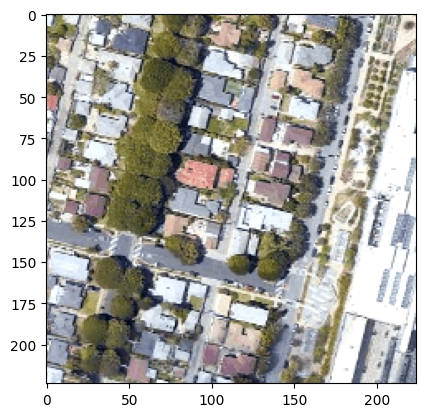

In [10]:
img, mask = ds[3]
display_image(img, normalization_params=NORMALIZATION_PARAMS_EQUALIZED)

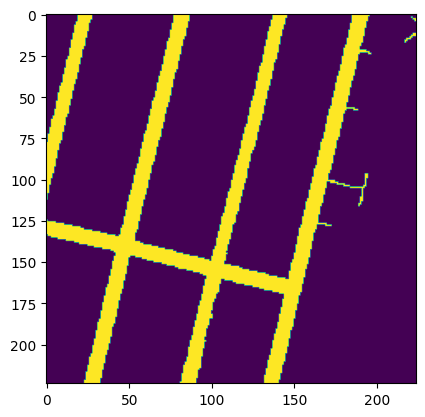

In [11]:
display_image(mask)

### Augmentations

In [557]:
from torchvision.transforms.functional import equalize
from src.transforms import NORMALIZATION_PARAMS_2022
import torchvision
from torchvision.io import ImageReadMode

In [567]:
img = read_image(ds.img_paths[4], mode=ImageReadMode.RGB)

In [573]:
from torchvision.transforms import Normalize
NORMALIZATION_PARAMS_2022 = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
}

NORMALIZATION_TRANSFORM = Normalize(**NORMALIZATION_PARAMS_2022)

In [473]:
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
])

In [452]:
# use cv2 to load image as uint8 numpy array (as suggested by albumentations)
import cv2

img = cv2.imread(ds.img_paths[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(ds.mask_paths[3])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

transformed = transform(image=img, mask=mask)
img, mask = torch.from_numpy(transformed['image']).permute(2, 0, 1), torch.from_numpy(transformed['mask']).permute(2, 0, 1)

In [478]:
# use torch tensor images from the dataset
img, mask = ds[3]

transformed = transform(image=img.permute(1, 2, 0).numpy(), mask=mask.permute(1, 2, 0).numpy())
img, mask = torch.from_numpy(transformed['image']).permute(2, 0, 1), torch.from_numpy(transformed['mask']).permute(2, 0, 1)

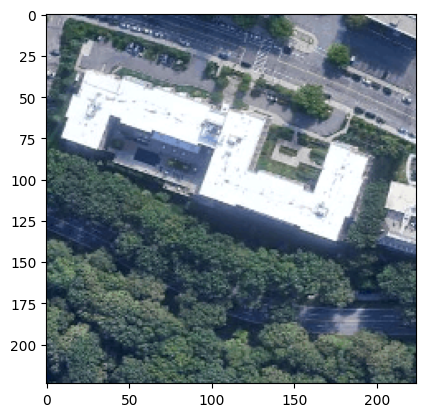

In [479]:
display_image(img)

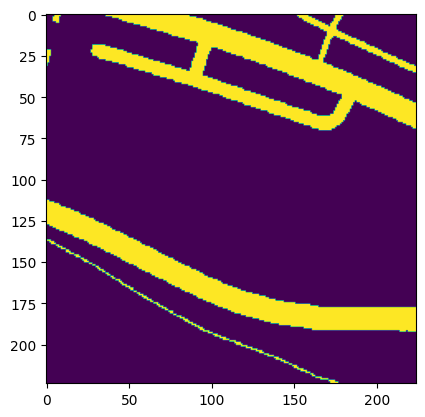

In [476]:
display_image(mask)

In [21]:
for X, y in dl_train:
    print(X.shape)
    print(y.shape)
    # print(X)
    # print(y)
    
    out = model(X)
    print(out.shape)
    print(out.min())
    print(out.max())
    break

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])
torch.Size([8, 1, 112, 112])
tensor(0.0117, grad_fn=<MinBackward1>)
tensor(0.9952, grad_fn=<MaxBackward1>)


### Histogram Equalization

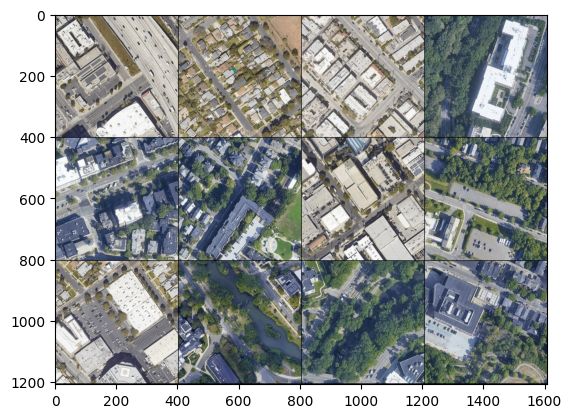

In [718]:
N = 12
display_image(torch.stack([read_image(f, mode=ImageReadMode.RGB) for f in ds.img_paths[:N]]), nrow=4)

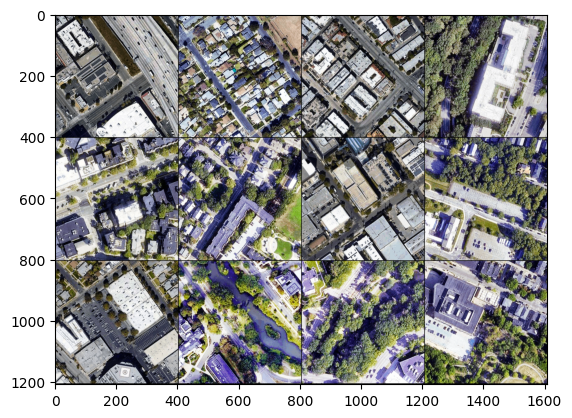

In [719]:
display_image(torch.stack([equalize(read_image(f, mode=ImageReadMode.RGB)) for f in ds.img_paths[:N]]), nrow=4)

In [734]:
def display_eq_sample(idx):
    display_image(torch.stack([read_image(ds_add.img_paths[idx], mode=ImageReadMode.RGB), equalize(read_image(ds_add.img_paths[idx], mode=ImageReadMode.RGB))]))

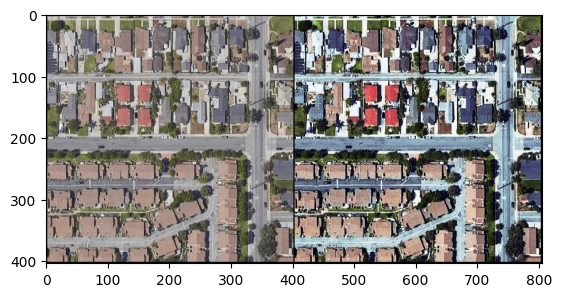

In [736]:
display_eq_sample(2000)

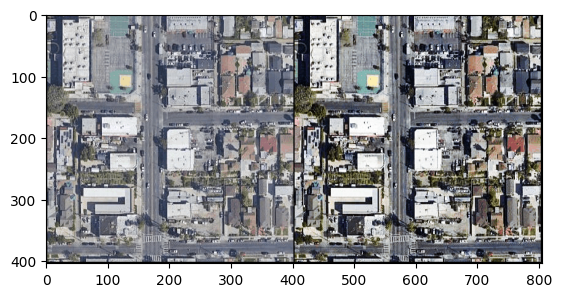

In [737]:
display_eq_sample(1500)

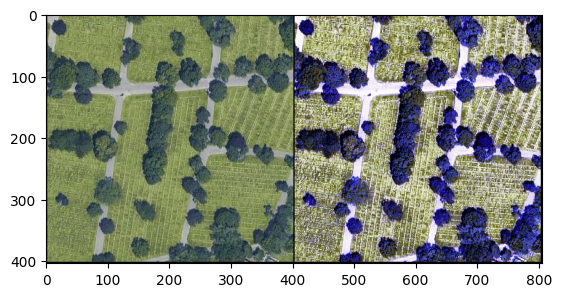

In [738]:
display_eq_sample(1000)

### Calculate Mean and Standard Deviation of Image Dataset

In [608]:
norm_t = Normalize(mean=(0.4931, 0.4934, 0.4928), std=(0.2903, 0.2905, 0.2906))

In [714]:
imgs = []
for img_path in ds.img_paths:
    res = equalize(read_image(img_path, mode=ImageReadMode.RGB))/255
    #res = norm_t(res)
    imgs.append(res)
imgs = torch.stack(imgs)

In [715]:
mean = torch.mean(imgs, dim=(0, 2, 3))
std = torch.std(imgs, dim=(0, 2, 3))

In [716]:
std

tensor([0.2903, 0.2905, 0.2906])

## Miscellaneous

In [7]:
def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

In [13]:
a = torch.ones(1, 1, 20, 20)
b = torch.zeros(1, 1, 20, 20)
b[0, 0, :10, :10] = 1

In [29]:
import torch

def binary_f1_score(y_true, y_pred):
    """
    Compute binary F1 score between y_true and y_pred.

    Args:
    - y_true: true labels (torch.Tensor)
    - y_pred: predicted labels (torch.Tensor)

    Returns:
    - binary F1 score (torch.Tensor)
    """
    # Convert y_pred to binary values
    y_pred = torch.round(y_pred)

    # Compute true positives, false positives, and false negatives
    tp = torch.sum((y_true == 1) & (y_pred == 1)).float()
    fp = torch.sum((y_true == 0) & (y_pred == 1)).float()
    fn = torch.sum((y_true == 1) & (y_pred == 0)).float()

    # Compute precision, recall, and F1 score
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1_score = 2 * precision * recall / (precision + recall + 1e-10)

    return f1_score


class PatchF1ScoreNew(PatchAccuracy):
    """
    Evaluation metric used this year.
    1. Splits the prediction and target into patches of size patch_size.
    2. Binarizes every patch by comparing the mean of the patch activations to the cutoff value.
    3. Computes the F1-Score over the binarized patches.
    """
    def __init__(self, patch_size: int = 16, cutoff: float = 0.25, eps: float = 1e-10):
        super(PatchF1ScoreNew, self).__init__(patch_size=patch_size, cutoff=cutoff)
        
        self.eps = eps

    def forward(self, y_hat, y):

        patches_hat, patches = self.binarize_patches(y_hat, y)
        
        # Compute true positives, false positives, and false negatives
        tp = torch.sum((patches_hat == 1) & (patches == 1)).float()
        fp = torch.sum((patches_hat == 1) & (patches == 0)).float()
        fn = torch.sum((patches_hat == 0) & (patches == 1)).float()

        # Compute precision, recall, and F1 score
        precision = tp / (tp + fp + self.eps)
        recall = tp / (tp + fn + self.eps)
        f1_score = 2 * precision * recall / (precision + recall + self.eps)

        return f1_score

In [16]:
from src.metrics import PatchAccuracy, PatchF1Score

In [30]:
pa = PatchAccuracy(patch_size=2, cutoff=0.25)
pf = PatchF1Score(patch_size=2, cutoff=0.25)
pfn = PatchF1ScoreNew(patch_size=2, cutoff=0.25)

In [18]:
pa(a, b)

tensor(0.2500)

In [19]:
pf(a, b)

tensor(0.4000)

In [31]:
pfn(a, b)

tensor(0.4000)